In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import ast
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
sns.set()

from pyathena import connect

In [3]:
conn = connect(s3_staging_dir='s3://aws-athena-query-results-415718651610-us-east-1', region_name='us-east-1')
df = pd.read_sql("SELECT * FROM das.ocorrencias limit 50000", conn)

Failed to execute query.
Traceback (most recent call last):
  File "/home/ecsn/anaconda3/envs/env_new/lib/python3.6/site-packages/pyathena/common.py", line 154, in _execute
    **request)
  File "/home/ecsn/anaconda3/envs/env_new/lib/python3.6/site-packages/pyathena/util.py", line 57, in retry_api_call
    return retry(func, *args, **kwargs)
  File "/home/ecsn/anaconda3/envs/env_new/lib/python3.6/site-packages/tenacity/__init__.py", line 358, in call
    do = self.iter(retry_state=retry_state)
  File "/home/ecsn/anaconda3/envs/env_new/lib/python3.6/site-packages/tenacity/__init__.py", line 319, in iter
    return fut.result()
  File "/home/ecsn/anaconda3/envs/env_new/lib/python3.6/concurrent/futures/_base.py", line 425, in result
    return self.__get_result()
  File "/home/ecsn/anaconda3/envs/env_new/lib/python3.6/concurrent/futures/_base.py", line 384, in __get_result
    raise self._exception
  File "/home/ecsn/anaconda3/envs/env_new/lib/python3.6/site-packages/tenacity/__init__.py"

DatabaseError: Execution failed on sql: SELECT * FROM das.ocorrencias limit 50000
Unable to locate credentials
unable to rollback

In [3]:
df.describe()

,duracao_s
count,16513.000000
mean,3371.716284
std,13434.891059
min,0.000000
25%,120.000000
50%,300.000000
75%,870.000000
max,259080.000000


In [4]:
df.head()

,nome,host,abertura,fechamento,duracao_s
0,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900
1,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900
2,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900
3,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900
4,Utilização de Download no link INTEGRA_VIVO ac...,INT-poa-fw,2019-03-29 16:05:05,2019-03-29 16:06:04,59


In [5]:
df.dropna(inplace=True)

In [6]:
table = pd.DataFrame(df)

In [7]:
np.unique(table.nome.values)

array(['% used CPU is overloaded : 80.77 % (warn)',
       '% used CPU is overloaded : 82.51 % (warn)',
       '% used CPU is overloaded : 82.64 % (warn)', ..., 'sTarefasDTEF8',
       'sv-ca-spy has just been restarted',
       '{$TIPO3}: PAY-spo-imaxis-vpn inacessível a partir do servidor PAY-smcd60csrv15'],
      dtype=object)

In [8]:
lbe = LabelEncoder()
table['name_encoded'] = lbe.fit_transform(table.nome.values)

In [9]:
table.head()

,nome,host,abertura,fechamento,duracao_s,name_encoded
0,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900,716
1,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900,716
2,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900,716
3,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900,716
4,Utilização de Download no link INTEGRA_VIVO ac...,INT-poa-fw,2019-03-29 16:05:05,2019-03-29 16:06:04,59,3656


### Forma da distribuição da duração dos problemas

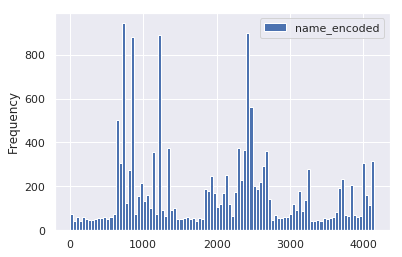

In [43]:
table[['nome','name_encoded']].plot.hist(bins=100)

In [91]:
print(f'Há um total de {len(np.unique(table.name_encoded.values))} occorências nesta amostra')

Há um total de 4150 occorências nesta amostra


### Duracação médias dos problemas (início até serem resolvidos)

A grande maioria é resolvido entre 0 e 25000 segundos. Há alguns pontos fora da normalidade que demoram mais para serem resolvidos como pode ser visto principalmente no boxplot.

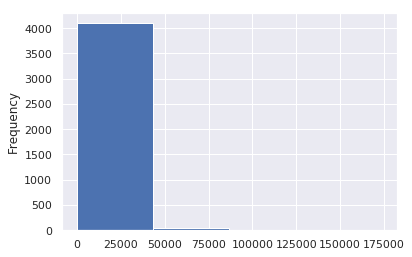

In [75]:
table.groupby('name_encoded').duracao_s.mean().plot.hist(bins=4)

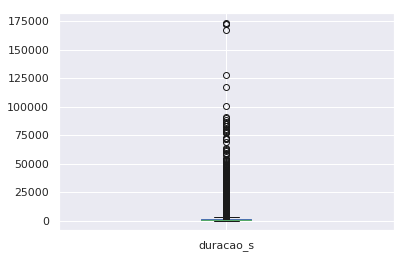

In [76]:
table.groupby('name_encoded').duracao_s.mean().plot.box()

## Análise da duração do problema que mais ocorre

In [46]:
key_value = dict(table.groupby('name_encoded').name_encoded.count())

In [56]:
greater_problem = max(key_value, key=key_value.get)

In [90]:
print(f'O problema que mais ocorre é o {table[table["name_encoded"]==greater_problem]["nome"].iloc[0]}')

O problema que mais ocorre é o Symantec - Nao localizado Relatorio


In [95]:
sub_table =table[table['name_encoded']==greater_problem]

In [96]:
sub_table[['duracao_s']].describe()

,duracao_s
count,718.000000
mean,1651.931755
std,8154.441305
min,31.000000
25%,73.000000
50%,151.000000
75%,200.000000
max,105511.000000


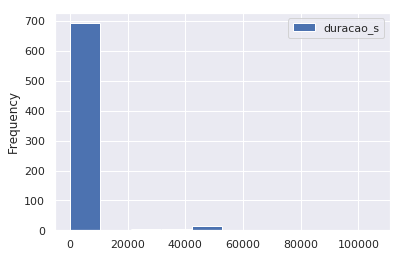

In [97]:
sub_table[['duracao_s']].plot.hist()

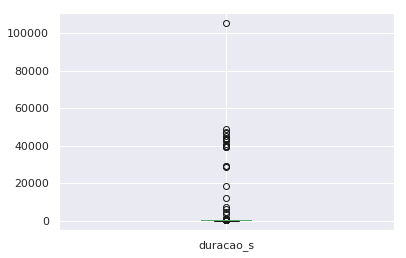

In [98]:
sub_table[['duracao_s']].plot.box()